In [2]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']


In [82]:
pwd


'/Users/clu/repos/federated-conformal'

In [3]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [4]:
# path_to_experiments = Path('../experiments/')
path_to_experiments = Path('experiments/')

In [91]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    model = 'resnet18'
    # model = 'efficientnet-b1'
    partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    # experiments = {
    #     'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
    #     'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
    #     'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
    #     'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    #     'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    # }
    log_experiments = {
        # 'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        # 'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_{partition}'), dataset=dataset),
    }
    square_experiments = {
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_squared_loss_{partition}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_squared_loss_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    log_experiments = {
        # 'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        # 'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
    }
    square_experiments = {
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_squared_loss'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_squared_loss'), dataset=dataset),
    }
    
log_experiments = dict(filter(snd, log_experiments.items()))
square_experiments = dict(filter(snd, square_experiments.items()))

In [92]:
for k, v in log_experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    log_experiments[k]['temp_val_scores'] = val_scores
    log_experiments[k]['temp_test_scores'] = test_scores
    
for k, v in square_experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    square_experiments[k]['temp_val_scores'] = val_scores
    square_experiments[k]['temp_test_scores'] = test_scores

In [93]:
log_val_scores = log_experiments['tct']['temp_val_scores']
log_val_targets = log_experiments['tct']['val_targets']
log_test_scores = log_experiments['tct']['temp_test_scores']
log_test_targets = log_experiments['tct']['test_targets']

square_val_scores = square_experiments['tct']['temp_val_scores']
square_val_targets = square_experiments['tct']['val_targets']
square_test_scores = square_experiments['tct']['temp_test_scores']
square_test_targets = square_experiments['tct']['test_targets']

log_q_lac = cp.calibrate_lac(log_val_scores, log_val_targets, alpha=0.1)
square_q_lac = cp.calibrate_lac(square_val_scores, square_val_targets, alpha=0.1)
log_psets_lac = cp.inference_lac(log_test_scores, log_q_lac)
square_psets_lac = cp.inference_lac(square_test_scores, square_q_lac)
log_q_aps = cp.calibrate_aps(log_val_scores, log_val_targets, alpha=0.1)
square_q_aps = cp.calibrate_aps(square_val_scores, square_val_targets, alpha=0.1)
log_psets_aps = cp.inference_aps(log_test_scores, log_q_aps)
square_psets_aps = cp.inference_aps(square_test_scores, square_q_aps)
log_q_raps = cp.calibrate_raps(log_val_scores, log_val_targets, alpha=0.1, lam_reg=0.0001)
square_q_raps = cp.calibrate_raps(square_val_scores, square_val_targets, alpha=0.1, lam_reg=0.0001)
log_psets_raps = cp.inference_raps(log_test_scores, log_q_raps, lam_reg=0.0001)
square_psets_raps = cp.inference_raps(square_test_scores, square_q_raps, lam_reg=0.0001)

In [94]:
print('log loss')
print('lac', cp.get_size(log_psets_lac))
print('aps', cp.get_size(log_psets_aps))
print('raps', cp.get_size(log_psets_raps))

print('squared loss')
print('lac', cp.get_size(square_psets_lac))
print('aps', cp.get_size(square_psets_aps))
print('raps', cp.get_size(square_psets_raps))

log loss
lac 5.0
aps 17.4
raps 7.0
squared loss
lac 9.2
aps 80.9
raps 20.8


In [95]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

for k, v in square_experiments.items():
    print(k)
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    print(accuracy(val_logits, val_targets))
    print(accuracy(test_logits, test_targets))
print()
for k, v in log_experiments.items():
    print(k)
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    print(accuracy(val_logits, val_targets))
    print(accuracy(test_logits, test_targets))

tct
0.6439999938011169
0.6381111145019531
tct_iid
0.6809999942779541
0.6581110954284668

tct
0.593999981880188
0.6079999804496765
tct_iid
0.6480000019073486
0.6317777633666992


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


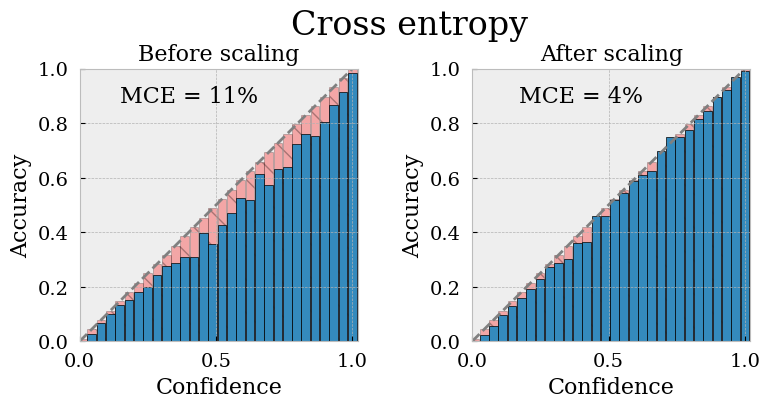

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


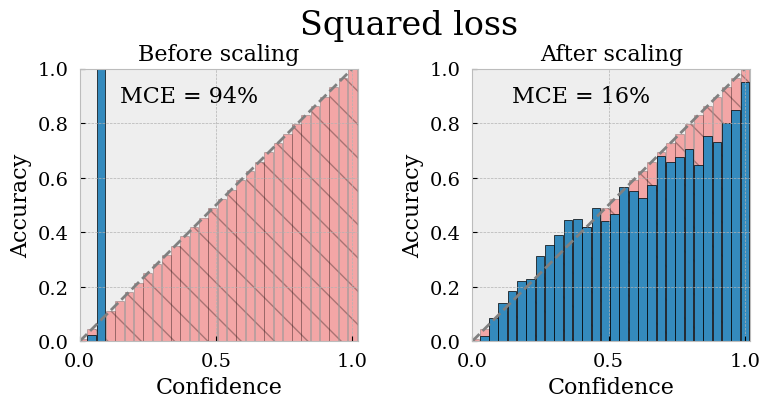

In [96]:
reload(ts)
# for exp in ('fedavg', 'fedavg_iid'):
# for exp in ('central', 'tct'):
for exp in log_experiments.keys():
    if exp != 'tct': continue
    preds = log_experiments[exp]
    scores  = preds['test_scores']
    targets = preds['test_targets']
    ts.draw_reliability_graph(scores, targets, use_temp_scale=True, plot=False, title=f'Cross entropy', num_bins=30, save=fig_dir / f'{dataset}-calibration-ce-loss.eps')
    
for exp in square_experiments.keys():
    if exp != 'tct': continue
    preds = square_experiments[exp]
    scores  = preds['test_scores']
    targets = preds['test_targets']
    ts.draw_reliability_graph(scores, targets, use_temp_scale=True, plot=False, title=f'Squared loss', num_bins=30,save=fig_dir / f'{dataset}-calibration-mse-loss.eps')
    